In [1]:

import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
sys.path.append(current_path+'/../calculate_tangent/')


In [3]:

def simple_magnitude(freqArray):
    xLim = [0, 360]
    binValue = 10.01
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)

    freqArray_circle = np.ones(binNum)
    freqArray_circle = freqArray_circle/sum(freqArray_circle*binValue)

    magnitude_max = np.max(abs(freqArray - freqArray_circle))/np.average(freqArray_circle)
    magnitude_ave = np.average(abs(freqArray - freqArray_circle))/np.average(freqArray_circle)

    magnitude_stan = np.sqrt(np.sum((abs(freqArray - freqArray_circle)/np.average(freqArray_circle) - magnitude_ave)**2)/binNum)

    return magnitude_ave, magnitude_stan

    # coeff_high = abs(np.cos((xCor-90)/180*np.pi))
    # coeff_low = abs(np.cos((xCor)/180*np.pi))
    # return np.sum(freqArray * coeff_high)/np.sum(freqArray * coeff_low)

def find_fittingEllipse2(array): #failure
    K_mat = []
    Y_mat = []

    # Get the self-variable
    X = array[:,0]
    Y = array[:,1]

    K_mat = np.hstack([X**2, X*Y, Y**2, X, Y])
    Y_mat = np.ones_like(X)

    X_mat = np.linalg.lstsq(K_mat, Y_mat)[0].squeeze()
    # X_mat = (K_mat.T*K_mat).I * K_mat.T * Y_mat

    print('The ellipse is given by {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(X_mat[0], X_mat[1], X_mat[2], X_mat[3], X_mat[4]))
    print(X_mat)

    return X_mat

def get_poly_center(micro_matrix, step):
    # Get the center of all non-periodic grains in matrix
    num_grains = int(np.max(micro_matrix[step,:]))
    center_list = np.zeros((num_grains,2))
    sites_num_list = np.zeros(num_grains)
    ave_radius_list = np.zeros(num_grains)
    coord_refer_i = np.zeros((micro_matrix.shape[1], micro_matrix.shape[2]))
    coord_refer_j = np.zeros((micro_matrix.shape[1], micro_matrix.shape[2]))
    for i in range(micro_matrix.shape[1]):
        for j in range(micro_matrix.shape[2]):
            coord_refer_i[i,j] = i
            coord_refer_j[i,j] = j

    table = micro_matrix[step,:,:,0]
    for i in range(num_grains):
        sites_num_list[i] = np.sum(table == i+1)

        if (sites_num_list[i] < 500) or \
           (np.max(coord_refer_i[table == i+1]) - np.min(coord_refer_i[table == i+1]) == micro_matrix.shape[1]) or \
           (np.max(coord_refer_j[table == i+1]) - np.min(coord_refer_j[table == i+1]) == micro_matrix.shape[2]): # grains on bc are ignored
          center_list[i, 0] = 0
          center_list[i, 1] = 0
          sites_num_list[i] == 0
        else:
          center_list[i, 0] = np.sum(coord_refer_i[table == i+1]) / sites_num_list[i]
          center_list[i, 1] = np.sum(coord_refer_j[table == i+1]) / sites_num_list[i]
    ave_radius_list = np.sqrt(sites_num_list / np.pi)

    return center_list, ave_radius_list

def get_poly_statistical_radius(micro_matrix, sites_list, step):
    # Get the max offset of average radius and real radius
    center_list, ave_radius_list = get_poly_center(micro_matrix, step)
    num_grains = int(np.max(micro_matrix[step,:]))

    max_radius_offset_list = np.zeros(num_grains)
    for n in range(num_grains):
        center = center_list[n]
        ave_radius = ave_radius_list[n]
        sites = sites_list[n]

        if ave_radius != 0:
          for sitei in sites:
              [i,j] = sitei
              current_radius = np.sqrt((i - center[0])**2 + (j - center[1])**2)
              radius_offset = abs(current_radius - ave_radius)
              if radius_offset > max_radius_offset_list[n]: max_radius_offset_list[n] = radius_offset

          max_radius_offset_list[n] = max_radius_offset_list[n] / ave_radius

    max_radius_offset = np.average(max_radius_offset_list[max_radius_offset_list!=0])
    area_list = np.pi*ave_radius_list*ave_radius_list
    if np.sum(area_list) == 0: max_radius_offset = 0
    else: max_radius_offset = np.sum(max_radius_offset_list * area_list) / np.sum(area_list)

    return max_radius_offset

def get_poly_statistical_ar(micro_matrix, step):
    # Get the average aspect ratio
    num_grains = int(np.max(micro_matrix[step,:]))
    sites_num_list = np.zeros(num_grains)
    coord_refer_i = np.zeros((micro_matrix.shape[1], micro_matrix.shape[2]))
    coord_refer_j = np.zeros((micro_matrix.shape[1], micro_matrix.shape[2]))
    for i in range(micro_matrix.shape[1]):
        for j in range(micro_matrix.shape[2]):
            coord_refer_i[i,j] = i
            coord_refer_j[i,j] = j

    aspect_ratio_i = np.zeros((num_grains,2))
    aspect_ratio_j = np.zeros((num_grains,2))
    aspect_ratio = np.zeros(num_grains)
    table = micro_matrix[step,:,:,0]

    aspect_ratio_i_list = [[] for _ in range(int(num_grains))]
    aspect_ratio_j_list = [[] for _ in range(int(num_grains))]
    for i in range(micro_matrix.shape[1]):
        for j in range(micro_matrix.shape[2]):
            grain_id = int(table[i][j]-1)
            sites_num_list[grain_id] +=1
            aspect_ratio_i_list[grain_id].append(coord_refer_i[i][j])
            aspect_ratio_j_list[grain_id].append(coord_refer_j[i][j])

    for i in range(num_grains):
        aspect_ratio_i[i, 0] = len(list(set(aspect_ratio_i_list[i])))
        aspect_ratio_j[i, 1] = len(list(set(aspect_ratio_j_list[i])))
        if aspect_ratio_j[i, 1] == 0: aspect_ratio[i] = 0
        else: aspect_ratio[i] = aspect_ratio_i[i, 0] / aspect_ratio_j[i, 1]

    # aspect_ratio = np.average(aspect_ratio[aspect_ratio!=0])
    aspect_ratio = np.sum(aspect_ratio * sites_num_list) / np.sum(sites_num_list)

    return aspect_ratio

def get_normal_vector(grain_structure_figure_one, grain_num):
    nx = grain_structure_figure_one.shape[0]
    ny = grain_structure_figure_one.shape[1]
    ng = np.max(grain_structure_figure_one)
    cores = 32
    loop_times = 5
    P0 = grain_structure_figure_one
    R = np.zeros((nx,ny,2))
    smooth_class = linear2d.linear_class(nx,ny,ng,cores,loop_times,P0,R)

    smooth_class.linear_main("inclination")
    P = smooth_class.get_P()
    # sites = smooth_class.get_gb_list(1)
    # print(len(sites))
    # for id in range(2,grain_num+1): sites += smooth_class.get_gb_list(id)
    # print(len(sites))
    sites = smooth_class.get_all_gb_list()
    sites_together = []
    for id in range(len(sites)): sites_together += sites[id]
    print("Total num of GB sites: " + str(len(sites_together)))

    return P, sites_together, sites

def get_normal_vector_slope(P, sites, step, para_name, bias=None):
    xLim = [0, 360]
    binValue = 10.01
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)

    freqArray = np.zeros(binNum)
    degree = []
    for sitei in sites:
        [i,j] = sitei
        dx,dy = myInput.get_grad(P,i,j)
        degree.append(math.atan2(-dy, dx) + math.pi)
        # if dx == 0:
        #     degree.append(math.pi/2)
        # elif dy >= 0:
        #     degree.append(abs(math.atan(-dy/dx)))
        # elif dy < 0:
        #     degree.append(abs(math.atan(dy/dx)))
    for i in range(len(degree)):
        freqArray[int((degree[i]/math.pi*180-xLim[0])/binValue)] += 1
    freqArray = freqArray/sum(freqArray*binValue)

    if bias is not None:
        freqArray = freqArray + bias
        freqArray = freqArray/sum(freqArray*binValue)
    # Plot
    # plt.close()
    # fig = plt.figure(figsize=(5, 5))
    # ax = plt.gca(projection='polar')

    # ax.set_thetagrids(np.arange(0.0, 360.0, 20.0),fontsize=14)
    # ax.set_thetamin(0.0)
    # ax.set_thetamax(360.0)

    # ax.set_rgrids(np.arange(0, 0.008, 0.004))
    # ax.set_rlabel_position(0.0)  # 标签显示在0°
    # ax.set_rlim(0.0, 0.008)  # 标签范围为[0, 5000)
    # ax.set_yticklabels(['0', '0.004'],fontsize=14)

    # ax.grid(True, linestyle="-", color="k", linewidth=0.5, alpha=0.5)
    # ax.set_axisbelow('True')
    plt.plot(np.append(xCor,xCor[0])/180*math.pi, np.append(freqArray,freqArray[0]), linewidth=2, label=para_name)

    # fitting
    fit_coeff = np.polyfit(xCor, freqArray, 1)
    return freqArray

print("Done")

Done


## Kernel

In [4]:

if __name__ == '__main__':
    # File name
    npy_file_folder_iso = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_multiCoreCompare/results/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_wellEnergy/results/"
    TJ_energy_type_060 = "0.6"
    TJ_energy_type_080 = "0.8"
    TJ_energy_type_090 = "0.9"
    TJ_energy_type_095 = "0.95"
    TJ_energy_type_099 = "0.99"

    # energy_function = "Cos"
    energy_function = "Cosmin1"
    npy_file_name_iso = "p_ori_ave_aveE_20000_multiCore32_delta0.0_m2_J1_refer_1_0_0_seed56689_kt066.npy"
    # npy_file_name_aniso_060 = f"p_aveE_20000_{energy_function}_delta{TJ_energy_type_060}_J1_refer_1_0_0_seed56689_kt066.npy"
    npy_file_name_aniso_080 = f"p_aveE_20000_{energy_function}_delta{TJ_energy_type_080}_J1_refer_1_0_0_seed56689_kt0.66.npy"
    npy_file_name_aniso_090 = f"p_aveE_20000_{energy_function}_delta{TJ_energy_type_090}_J1_refer_1_0_0_seed56689_kt0.66.npy"
    # npy_file_name_aniso_095 = f"p_aveE_20000_{energy_function}_delta{TJ_energy_type_095}_J1_refer_1_0_0_seed56689_kt0.66.npy"
    # npy_file_name_aniso_099 = f"p_aveE_20000_{energy_function}_delta{TJ_energy_type_099}_J1_refer_1_0_0_seed56689_kt0.66.npy"


    # Initial data
    npy_file_iso = np.load(npy_file_folder_iso + npy_file_name_iso)
    # npy_file_aniso_060 = np.load(npy_file_folder + npy_file_name_aniso_060)
    npy_file_aniso_080 = np.load(npy_file_folder + npy_file_name_aniso_080)
    npy_file_aniso_090 = np.load(npy_file_folder + npy_file_name_aniso_090)
    # npy_file_aniso_095 = np.load(npy_file_folder + npy_file_name_aniso_095)
    # npy_file_aniso_099 = np.load(npy_file_folder + npy_file_name_aniso_099)
    # print(f"The 0.6 data size is: {npy_file_aniso_060.shape}")
    print(f"The 0.8 data size is: {npy_file_aniso_080.shape}")
    print(f"The 0.90 data size is: {npy_file_aniso_090.shape}")
    # print(f"The 0.95 data size is: {npy_file_aniso_095.shape}")
    # print(f"The 0.99 data size is: {npy_file_aniso_099.shape}")
    print(f"The iso data size is: {npy_file_iso.shape}")
    print("READING DATA DONE")

    # Initial container
    initial_grain_num = 20000
    step_num = npy_file_aniso_090.shape[0]
    # grain_num_aniso_060 = np.zeros(step_num)
    grain_num_aniso_080 = np.zeros(step_num)
    grain_num_aniso_090 = np.zeros(step_num)
    # grain_num_aniso_095 = np.zeros(step_num)
    # grain_num_aniso_099 = np.zeros(step_num)
    grain_num_iso = np.zeros(step_num)

    # Calculate the number of grains
    for i in range(11,step_num):
        # grain_num_aniso_060[i] = len(set(npy_file_aniso_060[i,:].flatten()))
        grain_num_aniso_080[i] = len(set(npy_file_aniso_080[i,:].flatten()))
        grain_num_aniso_090[i] = len(set(npy_file_aniso_090[i,:].flatten()))
        # grain_num_aniso_095[i] = len(set(npy_file_aniso_095[i,:].flatten()))
        # grain_num_aniso_099[i] = len(set(npy_file_aniso_099[i,:].flatten()))
        grain_num_iso[i] = len(set(npy_file_iso[i,:].flatten()))

    expected_grain_num = 500
    # special_step_distribution_060 = int(np.argmin(abs(grain_num_aniso_060 - expected_grain_num)))
    special_step_distribution_080 = int(np.argmin(abs(grain_num_aniso_080[11:] - expected_grain_num)))
    special_step_distribution_090 = int(np.argmin(abs(grain_num_aniso_090[11:] - expected_grain_num)))
    # special_step_distribution_095 = int(np.argmin(abs(grain_num_aniso_095 - expected_grain_num)))
    # special_step_distribution_099 = int(np.argmin(abs(grain_num_aniso_099 - expected_grain_num)))
    special_step_distribution_iso = int(np.argmin(abs(grain_num_iso[11:] - expected_grain_num)))
    print("Found time steps")

    # Get bias from kT test


The 0.8 data size is: (601, 2400, 2400, 1)
The 0.90 data size is: (403, 2400, 2400, 1)
The iso data size is: (601, 2400, 2400, 1)
READING DATA DONE
Found time steps


In [5]:

    label_list = ["0.0", "0.8", "0.9"]
    aniso_mag = np.zeros(len(label_list))
    aniso_mag_stand = np.zeros(len(label_list))
    aniso_rs = np.zeros(len(label_list))

    # Iso
    aniso_rs[0] = get_poly_statistical_ar(npy_file_iso, special_step_distribution_iso)
    print("iso done")

    aniso_rs[1] = get_poly_statistical_ar(npy_file_aniso_080, special_step_distribution_080)
    print("080 done")

    aniso_rs[2] = get_poly_statistical_ar(npy_file_aniso_090, special_step_distribution_090)
    print("090 done")


iso done
080 done
090 done


In [6]:
print(aniso_rs)

[1.01917463 1.69113312 3.61909214]


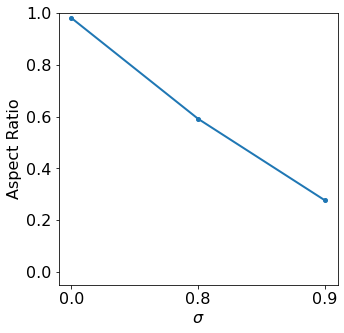

In [8]:

    plt.close()
    fig = plt.figure(figsize=(5, 5))
    # label_list = ["0.0", "0.6", "0.8", "0.9"]
    plt.plot(np.linspace(0,len(label_list)-1,len(label_list)), 1/aniso_rs, '.-', markersize=8, label=f'around {expected_grain_num} grains', linewidth=2)
    plt.xlabel(r"$\sigma$", fontsize=16)
    plt.ylabel("Aspect Ratio", fontsize=16)
    plt.xticks(np.linspace(0,len(label_list)-1,len(label_list)),label_list)
    # plt.legend(fontsize=16)
    plt.ylim([-0.05,1.0])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig(current_path + f"/figures/anisotropic_poly_20k_aspect_ratio_{energy_function}.png", dpi=400,bbox_inches='tight')